#### Inhaltsverzeichnis
* 1\. Einleitung 
* 2\. Einführung in den Datensatz 
    * 2.1\. Datenaufbereitung und Besonderheiten im Datensatz
    * 2.2\. Betriebswirtschaftliche Kennzahlen
* 3\. Marketing
    * 3.1\. Optimierung des Produktlayouts
    * 3.2\. Spezifische Marketingfragen aus der Belegschaft
    * 3.3\. Handlungsempfehlung für das Marketing
* 4\. Disposition
    * 4.1\. Erkenntnisse über regionale Unterschiede im Kaufverhalten der Kunden
    * 4.2\. Beantwortung der Mitarbeiterfragen
        * 4.2.1\. Schwankt die Popularität des Produktes 9390 (frozen peaches) zwischen den Regionen?
        * 4.2.2\. Sind die Produkte 9390, 2713, 21883 und 16753 in den gleichen Regionen populär und unpopulär, oder unterscheiden sich die Muster?
        * 4.2.3\. Welche Counties sind sich ähnlich in Hinblick auf den Produktmix?
        * 4.2.4\. Welche der TOP 50-Produkte sind sich ähnlich in Hinblick auf die regionale Verteilung?
    * 4.3\. Handlungsempfehlung für die Disposition

# 1. Einleitung

# 2. Einführung in den Datensatz

## Imports

In [1]:
# tables
import pandas as pd
# numerics
import numpy as np
# json
import json
# web requests
import requests
from urllib.request import urlopen
# statistics
from sklearn.cluster import KMeans
from scipy.stats import chi2, chi2_contingency, f_oneway

In [2]:
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# plotting maps
import geopandas

In [4]:
# graphs
import networkx as nx

In [5]:
import warnings
#for whatever reason ShapelyDeprecationWarning doesn't inherit from Deprecation warning
# so to hide it we have to hide all warnings. Yes it's very bad practice, but this is a presentation, have mercy
warnings.filterwarnings("ignore")

## Funktionsdefinition

#### Convenience

In [6]:
def autocomplete_product(stump):
    """ Autocomplete (Case Insensitive) Product Name and provide ID """
    # for each product
    for x in raw.product_name.unique():
        # if it contains provided stump
        if x.lower().__contains__(stump.lower()):
            # print name and id
            print(f"{x} - {name_to_id[x]}")

#### Graphen

In [7]:
def create_graph(df, name, plot=False, offline=True, notebook=False, nf=0.05):
    """
    Create Graph of products. Node size ~ totals sales. Edge strength ~ shared sales adjusted for total sales.
    
    :df -> Dataframe to generate edges from
    :name -> file suffix for html page
    :offline -> create html page with plot and display as new tab
    :notebook -> display in notebook
    :nf -> normalizing factor for path strenght. Smaller values => thicker edges
    """
    # create edgelist
    G = nx.from_pandas_edgelist(df, source="product_x", target="product_y", edge_attr=True)
    # position nodes using Fruchterman-Reingold force-directed algorithm
    pos_ = nx.spring_layout(G)
    
    # generate plotly trace for every edge
    edge_trace = []
    for edge in G.edges():

        if G.edges()[edge]['weight'] > 0:
            prod_1 = edge[0]
            prod_2 = edge[1]

            x0, y0 = pos_[prod_1]
            x1, y1 = pos_[prod_2]
            # generate hovertext (only displays on starting point. Bug in Plotly https://community.plotly.com/t/plotly-hover-event-not-getting-triggered-for-al-data-points/387)
            text   = str(id_to_name[prod_2]) + '--' + str(id_to_name[prod_1]) + ': ' + str(G.edges()[edge]['weight'])
            # calculate adjusted width
            width = G.edges()[edge]['weight']/(nf*prod_count[prod_1]+nf*prod_count[prod_2])
            # generate trace
            trace = go.Scatter(x = [x0, x1, None], y = [y0, y1, None],
                               line      = dict(width=width, color='green'),
                               hoverinfo = 'text',
                               text      = ([text]),
                               mode      = 'lines')
            # append to edge_trace list
            edge_trace.append(trace)
            
    # create empty node trace
    node_trace = go.Scatter(x = [], y = [],
                            text      = [],
                            textposition = "top center",
                            textfont_size = 10,
                            mode      = 'markers+text',
                            hoverinfo = 'none',
                            marker    = dict(color=[], size=[], line=None))
    # add every node to node_trace 
    for node in G.nodes():
        x, y = pos_[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['marker']['color'] += tuple(['cornflowerblue'])
        node_trace['marker']['size'] += tuple([np.log(prod_count[node])])
        node_trace['text'] += tuple([id_to_name[node]])
    # create layout
    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    # create figure
    fig = go.Figure(layout = layout)
    
    # add edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    
    # add node traces
    fig.add_trace(node_trace)
    
    # cleanup layout
    fig.update_layout(showlegend = False)
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)
    # display in specified way(s)
    if notebook:
        fig.show()
    if offline:
        po.plot(fig, filename=f'networks/network_{name}.html')

In [8]:
def cl_department(department):
    """
    Create Cooccurrency List for Department
    
    :department -> department for which to filter for
    """
    # filter and copy
    df = raw[raw.department == department][["order_id", "product_id"]].copy()
    # rename columns
    df.rename(columns={"order_id":"order", "product_id":"product"}, inplace=True)
    # create cooccurrency list
    # steps:
    # merge to self and drop rows with reflexive relationship
    # group by both products and count occurences
    # rename columns
    # filter duplicate rows
    # sort and reset index
    df_coocc = df.merge(df, on=['order']).query('product_x != product_y')\
        .groupby(['product_x','product_y'], as_index=False).count()\
        .rename(columns={'order':'weight'})\
        .query('product_x < product_y')\
        .sort_values(by="weight", ignore_index=True)
    return df_coocc

In [9]:
def graph_product(product_id, top_n=25, filter_dict=None, offline=True, notebook=False, nf=0.05):
    """
    Draw Cooccurrency Graph for specified Product
    
    :product_id -> center of graph
    :filter_dict -> limit by condition passsed as dict. To filter to county Alpine,
    pass filter_dict = {"county": "Alpine"}
    :top_n -> number of relationships to include (by absolute number of cooccurrencies)
    :offline -> create html page with plot and display as new tab
    :notebook -> display in notebook
    :nf -> normalizing factor for path strenght. Smaller values => thicker edges
    """
    # create copy
    df = raw.copy()
    # filter rows that dont satisfy conditions if filters are passed
    if filter_dict:
        for key in filter_dict.keys():
            df = df[df[key] == filter_dict[key]]
    df = df[["order_id", "product_id"]]
    # rename columns
    df.rename(columns={"order_id":"order", "product_id":"product"}, inplace=True)
    # create cooccurrency list
    # steps:
    # merge to self and filter to relevant rows
    # drop reflexive relationships
    # group by both products and count occurences
    # rename columns
    # filter duplicate rows
    # sort and reset index
    df_coocc = df.merge(df, on=['order']).query(f'product_x == {product_id} | product_y == {product_id}')\
            .query('product_x != product_y')\
            .groupby(['product_x','product_y'], as_index=False).count()\
            .rename(columns={'order':'weight'})\
            .query('product_x < product_y')\
            .sort_values(by="weight", ignore_index=True)
    # draw graph
    create_graph(df_coocc.tail(top_n), product_id, offline=offline, notebook=notebook, nf=nf)

#### Layouts

In [10]:
def check_pair(a,b):
    """ Lookup Cross Selling Rate for Targets a and b """
    # if either is 0, return 0
    if a == 0 or b == 0:
        return 0
    # lookup cross selling rate. If a,b dont cross sell, triggers Float conversion error and returns 0
    try:
        return float(df_layout.query(f"x == {a} & y == {b}")["cross_sell_rate"])
    except TypeError:
        return 0
    
def get_nbs(pos):
    """ Get Neighbors for any Given Position """
    # unpack pos and init nbs (neighbors)
    x,y = pos
    nbs = []
    # check x and y in bounds
    if 0<=x<rows and 0<=y<cols:
        # add top neighbor if exists
        if x > 0:
            nbs.append(grid[x-1,y])
        # add bottom neighbor if exists
        if x < rows-1:
            nbs.append(grid[x+1,y])
        # add left neighbor if exists
        if y > 0:
            nbs.append(grid[x,y-1])
        # add right neighbor if exists
        if y < cols-1:
            nbs.append(grid[x,y+1])
    return nbs

def score_tile(target, pos):
    """ Compute Score for Target at Pos """
    # sum up cross selling rates between target and all neighbors
    return sum([check_pair(target, other) for other in get_nbs(pos)])

def next_free():
    """ Return Next Free Position in Grid """
    # find all positions with 0 (=no target assigned)
    pos = np.where(grid==0)
    # return first x and y coordinate
    return pos[0][0], pos[1][0]

def place_target(pos, unplaced):
    """ Place Best Available Target at pos """
    # unpack pos
    x,y = pos
    # track score for each unplaced target in dictionary
    scores = {target: score_tile(target, pos) for target in unplaced}
    # find best target
    best_target = max(scores, key=scores.get)
    # place target in grid
    grid[x,y] = best_target
    # return list of unplaced without target that was just placed
    return unplaced[unplaced != best_target]

In [11]:
def get_layout(target="aisle_id", filter_dict=None, columns=3, random=False):
    """ 
    Construct 2D Layout for target based on Cross Selling rate 
    
    :filter_dict -> limit by condition passsed as dict. To filter to department canned goods,
    pass filter_dict = {"department_id": "canned goods"}
    :random -> don't use greedy heuristic and instead place randomly
    """

    # filter data to target and order_id
    global df_layout
    if filter_dict:
        for key in filter_dict.keys():
            df_layout = raw[raw[key] == filter_dict[key]][["order_id", target]].copy()
    else:
        df_layout = raw[["order_id", target]].copy()
    # create cooccurence list for all target pairs
    # steps
    # merge to self and filter to relevant rows
    # group by both targets and count occurences
    # rename columns
    df_layout = df_layout.merge(df_layout, on=['order_id']).query(f'{target}_x != {target}_y')\
                .groupby([f'{target}_x',f'{target}_y'], as_index=False).count()\
                .rename(columns={'order_id':'cross_sells', f'{target}_x':'x', f'{target}_y':'y'})
    # compute cross selling rate
    if target == "aisle_id":
        df_layout["cross_sell_rate"] = df_layout["cross_sells"] / df_layout["x"].apply(lambda x: aisle_count[x])
    elif target == "department_id":
        df_layout["cross_sell_rate"] = df_layout["cross_sells"] / df_layout["x"].apply(lambda x: dep_count[x])
    else:
        raise NotImplementedError(f"Sorry {target} is not supported yet")
    # sort
    df_layout.sort_values(by="cross_sell_rate", ascending=False, inplace=True, ignore_index=True)
    
    # define grid size
    global cols
    global rows
    # excuse the globals, this should have been a class 
    cols = columns
    # rows are given by number targets / columns rounded up
    rows = int(np.ceil(df_layout["x"].nunique()/cols))

    # initialize grid for both target and cross selling rate to neighbors
    global grid
    global score_grid
    # excuse the globals part 2: this really should have been a class
    grid = np.zeros((rows, cols))
    score_grid = np.zeros((rows, cols))
    
    # get list of all targets
    unplaced = df_layout.x.unique()
    
    # while some are unplaced
    while len(unplaced) > 0:
        # place best available target at next free position
        if random:
            rand_target = np.random.choice(unplaced)
            x,y = next_free()
            grid[x,y] = rand_target
            unplaced = unplaced[unplaced != rand_target]
        else:
            unplaced = place_target(next_free(), unplaced)

    # for every position
    for x in range(rows):
        for y in range(cols):
            # compute score and track in seperate matrix
            score_grid[x,y] = score_tile(grid[x,y], (x,y))
    return grid, score_grid

In [12]:
def draw_layout(grid, score_grid, target="aisle_id", filename="Unnamed", scale=15):
    """ 
    draw given layout colored by scores with aisle name as label 
    
    :grid -> aisle positions as matrix
    :score_grid -> corresponding cross selling rates
    :filename -> filename
    :scale -> size of plot
    """
    # get shape
    rows, cols = grid.shape
    # init figure
    fig, ax = plt.subplots(figsize=(scale,scale))
    # show cross selling rates 
    ax.matshow(score_grid, cmap=plt.cm.Greens)

    # for every position
    for x in range(rows):
        for y in range(cols):
            # add label name \n cross selling rate
            if target == "aisle_id":
                name = aisle_id_to_name[grid[x,y]] + f"\n {round(score_grid[x,y],3)}" if grid[x,y] in aisle_id_to_name.keys() else None
            elif target == "department_id":
                name = dep_id_to_name[grid[x,y]] + f"\n {round(score_grid[x,y],3)}" if grid[x,y] in dep_id_to_name.keys() else None
            else:
                raise NotImplementedError(f"Sorry {target} is not supported yet")
            ax.text(y,x, name, va='center', ha='center')
    fig.savefig(f"layouts/{filename}_{cols}.png")

#### Marketingfragen

In [13]:
def pipe(df,ids):
    """
    Returns a DataFrame that holds GeoData for each county, aswell as the
    relative product popularity for given product (ids)
    """
    df = df[df.product_id==ids] # only take values from given product
    fil = np.sort(df.county.unique()) # list of counties where given product was bought
    geo = np.sort(california_geojson.name.unique()) # list of all counties in california
    match = []
    unique = []
    for el in geo:
        if el in fil:
            match.append(el) 
        else:
            unique.append(el) # counties that dont hold values
    for el in unique: # for visualization purposes: counties witouht values need an aritificial row with 0 orders
        new_row = {'county':el, 'Koordinaten':california_geojson[california_geojson.name==el]['geometry'].values[0], 'product_id':0, 
                   'Anzahl Bestellungen':0,
                   'Bestellungen pro Produkt':0,
                   'Anteil Bestellungen':0}
        df = df.append(new_row, ignore_index=True)
        df.Koordinaten = df.Koordinaten.astype('geometry')
    return df

#### Warenkorb Reihenfolge Analyse

In [14]:
def compute_percentage(df, target_col="order_id", min_orders=100):
    """
    Compute percentage of reduced product sales in relation to total sales per product
    :df -> DataFrame to perform the operation on
    :target_col -> column in df to perform the operation on
    :min_orders -> minimum sales of product to be included 
    """
    # merge absolute prod sales and filter to satisfy min orders
    df = df.merge(prod_count.rename("abs_orders"), left_index=True, right_index=True).query(f"abs_orders > {min_orders}")
    # compute percentage
    df["percentage"] = df[target_col] / df["abs_orders"]
    # change index to product name from id
    df.index = df.index.map(lambda x: id_to_name[x])
    # return filtered and sorted
    return df[["abs_orders", "percentage"]].sort_values(by="percentage", ascending=False)

## Vorverarbeitung

In [15]:
# read raw data
raw = pd.read_parquet("shoppingcarts.parquet")

In [16]:
# create lookup tables for id to name and vice versa 
# for product
id_to_name = dict(zip(raw.product_id.unique(), raw.product_name.unique()))
name_to_id = dict(zip(raw.product_name.unique(), raw.product_id.unique()))
# for aisle
aisle_id_to_name = dict(zip(raw.aisle_id.unique(), raw.aisle.unique()))
aisle_name_to_id = dict(zip(raw.aisle.unique(), raw.aisle_id.unique()))
# for department
dep_id_to_name = dict(zip(raw.department_id.unique(), raw.department.unique()))
dep_name_to_id = dict(zip(raw.department.unique(), raw.department_id.unique()))

# create lookup table for dow
dow_table = {
    0: "Samstag",
    1: "Sonntag", 
    2: "Montag",
    3: "Dienstag",
    4: "Mittwoch", 
    5: "Donnerstag", 
    6: "Freitag"
}

In [17]:
raw["order_dow"] = raw["order_dow"].apply(lambda x: dow_table[x])

In [18]:
# count number of orders per product, aisle, department and county
prod_count = raw.groupby("product_id")["order_id"].count()
aisle_count = raw.groupby("aisle_id")["order_id"].count()
dep_count = raw.groupby("department_id")["order_id"].count()
county_count = raw.groupby("county")["order_id"].count()

## 2.1 Datenaufbereitung und Besonderheiten im Datensatz

#### Wie viele Produkte wurden an jedem Wochentag gekauft

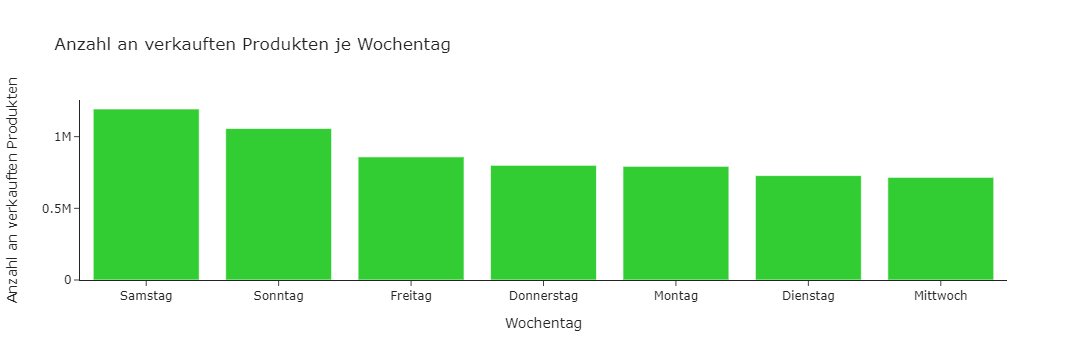

In [19]:
df1=raw.groupby("order_dow",as_index=False)["user_id"].count().sort_values(by="user_id",ascending=False).rename(columns={"user_id":"count_purchased_products"})

fig_dow = px.bar(df1, x='order_dow', y='count_purchased_products',title="Anzahl an verkauften Produkten je Wochentag", color_discrete_sequence=["limegreen"])
fig_dow.update_layout(xaxis_title="Wochentag",yaxis_title="Anzahl an verkauften Produkten", template="simple_white")
fig_dow.show()
# Erkenntnis: Anfangs der Woche werden die meisten Produkte  gekauft, zum Wochenende hin steigt es dann wieder an 

#### Welche Counties haben den kleinsten Anteil am Absatz?

In [20]:
df_c = raw.groupby(["order_id","county"],as_index=False)["user_id"].count().sort_values(by="user_id")
df_cg = df_c.groupby("county",as_index=False)["user_id"].count().sort_values(by="user_id").rename(columns={"user_id":"count_orders"})
df_cg["all_orders"]=raw["order_id"].nunique()
df_cg["ratio"] = df_cg["count_orders"] / df_cg["all_orders"]
df_cg = df_cg.sort_values(by="ratio",ascending=False)
df_least = df_cg.tail(4)
df_least.ratio.sum()*100
# Trinity, San Bernardino, Placer, Butte verzeichnen zusammen weniger als 0,04 % an allen Bestellungen

0.037028526843202375

## 2.2 Betriebswirtschaftliche Kennzahlen

### Anzahl Datenpunkte

In [21]:
raw.shape

(6145748, 14)

#### Anzahl Kunden

In [22]:
raw["user_id"].nunique()

37386

#### Anzahl Bestellungen

In [23]:
raw["order_id"].nunique()

604939

#### Durchschnittliche Anzahl an Bestellungen je Kunde

In [24]:
raw["order_id"].nunique() / raw["user_id"].nunique()

16.18089659230728

#### Durchschnittliche Anzahl an Produkten je Bestellung

In [25]:
len(raw) / raw["order_id"].nunique()

10.159285481676665

#### Durchschnittliche Zeit zw. Bestellung und nächster Bestellung

In [26]:
raw["days_since_prior_order"].mean()

11.334990163025108

#### Durchschnitt aus Durchschnittszeit zwischen Bestellungen pro User

In [27]:
df_user = raw.groupby("user_id",as_index=False)["days_since_prior_order"].mean()
df_user.days_since_prior_order.mean()

15.642788907413815

Erkenntnis: Kunden die häufig oder mehr bestellen, bestellen auch in kürzeren Abständen

#### Beliebteste Produktkategorien

In [28]:
df_departments=raw.groupby("department",as_index=False)["user_id"].count().sort_values(by="user_id",ascending=False).head(10).rename(columns={"user_id":"count_ordered_products_from_department"})
px.pie(df_departments,values="count_ordered_products_from_department",names="department", title="Top 10 meistverkaufte Produktkategorien",
       color_discrete_sequence=px.colors.sequential.algae)

#### Beliebteste Produkte

In [29]:
df_products=raw.groupby("product_name",as_index=False)["user_id"].count().sort_values(by="user_id",ascending=False).head(10).rename(columns={"user_id":"count_ordered_products"})
px.pie(df_products,values="count_ordered_products",names="product_name",title="Top 10 meistverkaufte Produkte", 
        color_discrete_sequence=px.colors.sequential.algae)

#### Anzahl an Bestellungen je Wochentag und Stunde

In [30]:
df7 = raw.groupby(["order_id","order_dow","order_hour_of_day"],as_index=False)["product_id"].count()
df8 = df7.groupby(["order_dow","order_hour_of_day"],as_index=False)["order_id"].count()
fig8 = px.line(df8,x="order_hour_of_day",y="order_id",color="order_dow", 
               color_discrete_sequence=["green","mediumseagreen","springgreen","lime","darkgreen","limegreen","greenyellow","forestgreen"])
fig8 = fig8.update_layout(title='Anzahl an Bestellungen je Tag und Stunde', xaxis_title='Stunde', yaxis_title="Anzahl an Bestellungen", template="simple_white")
fig8.show()

## "High time" ist montags 10 Uhr 

# 3. Marketing

## 3.1 Layout

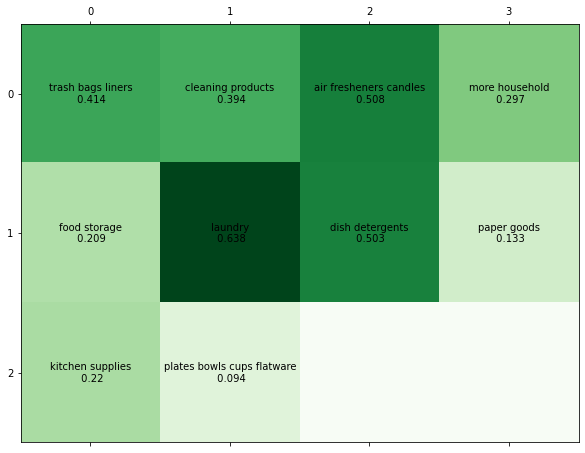

In [31]:
# find layout for aisles of department household
grid, score_grid = get_layout(target="aisle_id", filter_dict={"department": "household"}, columns=4, random=False)
draw_layout(grid, score_grid, filename="household", scale=10) 

avg score of random layout: 1.550323620219022
avg score of optimized layout: 2.0204818338171933


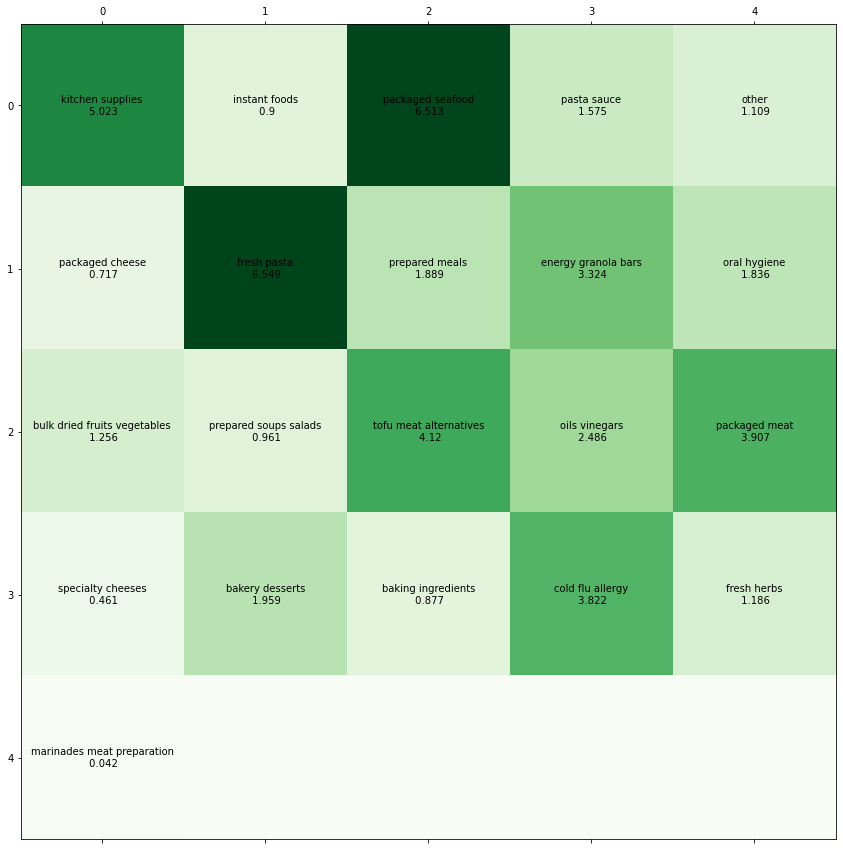

In [32]:
# draw layout for departments and compare random to heuristic
# random layout
grid, score_grid = get_layout(target="department_id", filter_dict=None, columns=5, random=True)
print(f"avg score of random layout: {np.mean(score_grid)}")
# heuristic
grid, score_grid = get_layout(target="department_id", filter_dict=None, columns=5, random=False)
print(f"avg score of optimized layout: {np.mean(score_grid)}")

draw_layout(grid, score_grid, filename="Departments")

## Graphen

In [33]:
# Use this to find Product-Ids
# shows all products containing stub. Case insensitive
autocomplete_product("Baby Spinach")

Organic Baby Spinach - 21903
Organic Baby Spinach Salad - 25931
Fresh European Style Baby Spinach - 41771
Super Spinach! Baby Spinach, Baby Bok Choy, Sweet Baby Kale - 36070
Baby Spinach - 11182
50/50 Mix Spring Mix and Baby Spinach Salad Blend - 21925
Baby Spinach Salad - 20919
Baby Spinach & Arugula - 28248
Happy Baby Spinach, Mango, and Pear Baby Food - 14491
50/50 Spring Mix & Baby Spinach - 36685
Organic Half Baby Spinach & Half Baby Arugula - 43513
Organic Half Spring Mix & Half Baby Spinach - 47915
Salad 50 Spring Mix/50 Baby Spinach - 31492
50/50 Spring Mix And Baby Spinach - 2847
Chopped Baby Spinach - 12126
Spring Mix & Baby Spinach, 50/50!, Family Size - 19055
Salad, Baby Spinach & Chicken - 12292


In [34]:
# create product graph
# offline -> create html page with plot and display as new tab
# notebook -> display in notebook
graph_product(product_id=21903, top_n=50, filter_dict={"county": "Alpine"}, nf=0.003)

## 3.2 Spezifische Marketingfrage aus der Belegschaft
####  Prüfen Sie, ob es belastbare Unterschiede im Wiederbestellverhalten zwischen den Produkten mit den product_ids 6217, 14778 und 23579 gibt. 

In [35]:
# filter to 6217, 14778 & 23579
# count reorders, compute fraction of reorders and avg time until reorder
# rename columns
df_q1 = raw[raw.product_id.isin([6217, 14778, 23579])].groupby("product_id")\
        .agg({"product_name": pd.Series.mode, "order_id": "count", "reordered": "mean", "days_since_prior_order": "mean"})\
        .rename(columns={"product_name": "Bezeichnung", "order_id": "Anzahl Bestellungen", "reordered": "Anteil Wiederbestellungen", "days_since_prior_order": "durchschn. Zeit bis Wiederbestellung"})
df_q1.round(2)

Bezeichnung  \
product_id                                                      
6217                                Pumpkin Spice Protein Bar   
14778               Organic Chocolate Chip Chewy Granola Bars   
23579       Peanut Butter Chocolate Chip Fruit & Nut Food Bar   

            Anzahl Bestellungen  Anteil Wiederbestellungen  \
product_id                                                   
6217                         46                       0.46   
14778                      1329                       0.62   
23579                      1357                       0.62   

            durchschn. Zeit bis Wiederbestellung  
product_id                                        
6217                                       10.13  
14778                                      11.43  
23579                                      11.00

In [36]:
# Aggregate data to show absolute numbers of reordered yes/no per product
q1_1 = raw[raw.product_id.isin([6217, 14778, 23579])]
# Perform chi2 test for independency for all 3 Products
total = chi2_contingency(pd.crosstab(q1_1['product_id'],q1_1['reordered'], margins = False, normalize = False), correction=False)
#Perform chi2 test for the 3 possibilities of combination
# Chi2 test without Product 23579
q1_2 = q1_1[q1_1["product_id"] != 23579]
no23579 = chi2_contingency(pd.crosstab(q1_2['product_id'],q1_2['reordered'], margins = False, normalize = False), correction=False)
# Chi2 test without Product 14778
q1_3 = q1_1[q1_1["product_id"] != 14778]
no14778 = chi2_contingency(pd.crosstab(q1_3['product_id'],q1_3['reordered'], margins = False, normalize = False), correction=False)
# Chi2 test without Product 6217
q1_4 = q1_1[q1_1["product_id"] != 6217]
no6217 = chi2_contingency(pd.crosstab(q1_4['product_id'],q1_4['reordered'], margins = False, normalize = False), correction=False)
#Summarize results of analysis in final DataFrame
df_stats = pd.DataFrame([
    ["...allen 3 Produkten", *total],
    ["...6217 & 14778", *no23579],
    ["...6217 & 23579", *no14778],
    ["...14778 & 23579", *no6217]])
df_stats.columns = ["Abhängigkeit zwischen...", "Teststatistik χ²", "p-Wert", "Freiheitsgrade", "Signifikant"]
df_stats["Signifikant"] = df_stats["p-Wert"] < 0.05

In [37]:
# Basis for chi2 tests
pd.crosstab(q1_1['product_id'],q1_1['reordered'], margins = False, normalize = False)
# results of chi2 tests
df_stats.round(2)

Abhängigkeit zwischen...  Teststatistik χ²  p-Wert  Freiheitsgrade  \
0     ...allen 3 Produkten              5.02    0.08               2   
1          ...6217 & 14778              4.97    0.03               1   
2          ...6217 & 23579              4.86    0.03               1   
3         ...14778 & 23579              0.01    0.93               1   

   Signifikant  
0        False  
1         True  
2         True  
3        False

Belastbarer Unterschied zwischen den Produkten:
- Product 6217 hebt sich im Kaufverhalten von Product 14778 & 23579 ab: deutlich geringere Anzahl absoluter Bestellungen (46) & geringerer Wiederbestellungsanteil (45.7%)
- Product 14778 & 23579 zeigen ähnliches Kaufverhalten: ähnliche Anzahl absoluter Bestellungen (1329,1357) & höherer Wiederbestellungsanteil (beide ca. 62 %)

Betrachtung von durchschn. Zeit bis Wiederbestellung schwierig, da starke Konfundierung mit restlichen Items im Warenkorb vorliegen sollte (damit ist der isolierte Vergleich der Wiederbestllungszeit zwischen den Produkten nicht ohne weiteres möglich)

## 3.3 Handlungsempfehlung für das Marketing

#### Produkte die häufig als erstes gekauft wurden

In [38]:
# count occurences of add to cart order = 1 for all products
first_prod = raw.query("add_to_cart_order == 1").groupby("product_id").agg({"order_id":"count"})
# compute percentage
first_prod = compute_percentage(first_prod)
# display top 5
first_prod.head(5)

abs_orders  percentage
product_id                                              
Sparkling Water, Bottles                 348    0.525862
White Multifold Towels                   202    0.490099
Minis to Go Natural Spring Water         154    0.474026
Water Mineral                            357    0.464986
Single Malt Scotch Whiskey               115    0.452174

#### Produkte die häufig als letztes gekauft wurden

In [39]:
# count products most frequently ordered last
max_per_order = raw.groupby("order_id").agg(last=("add_to_cart_order", max))
# filter to orders that were ordered last
last_prod = raw.merge(max_per_order, left_on="order_id", right_index=True).query("add_to_cart_order == last")
# groupby product id and count orders
last_prod = last_prod.groupby("product_id").agg({"order_id":"count"})
# compute percentage
last_prod = compute_percentage(last_prod)
# display top 5
last_prod.head(5)

abs_orders  percentage
product_id                                 
Pain Relief Tablets         130    0.584615
Organic Dark Roast          106    0.452830
Sugar Substitute            142    0.436620
Drinking Water             1146    0.436300
Wint-O-Green                270    0.414815

# 4. Disposition

## 4.1 Erkenntnisse über regionale Unterschiede im Kaufverhalten der Kunden

Die Top 10 Counties machen 48.9 % der Gesamtbestellungen aus.


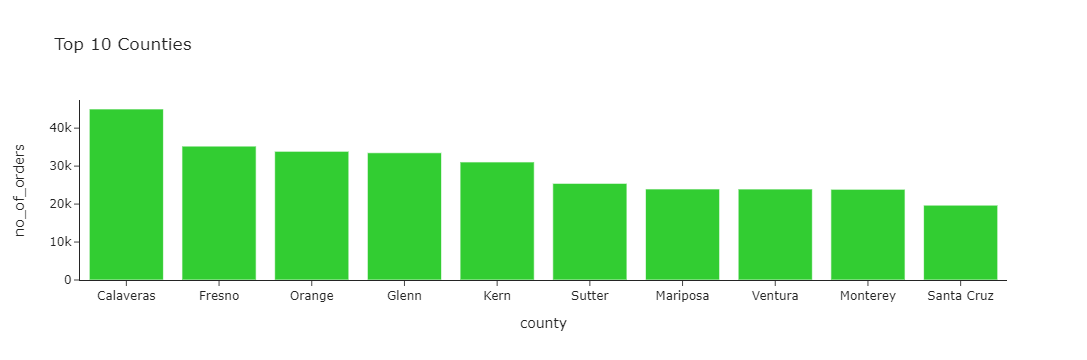

In [40]:
#Counties anhand der Bestellanzahl absteigend sortieren
top_counties = pd.DataFrame(raw.groupby('county', as_index=False)['order_id'].nunique()\
                            .sort_values(by= 'order_id', ascending=False))\
                            .rename(columns= {'order_id':'no_of_orders'})\
                            .head(10)
print('Die Top 10 Counties machen', (top_counties.head(10).no_of_orders.sum()/raw.order_id.nunique()*100).round(2), '% der Gesamtbestellungen aus.') 
px.bar(top_counties, x='county', y='no_of_orders', title= 'Top 10 Counties', color_discrete_sequence=["limegreen"],template='simple_white')

## 4.2 Beantwortung der Mitarbeiterfrage

#### 4.2.1 Schwankt die Popularität von Produkt 9390 zwischen den Regionen?

In [41]:
# filter to 9390, group by county and count orders
# sort and rename
df_q2 = raw[raw.product_id == 9390].groupby("county").agg({"order_id": "count"})\
        .sort_values(by="order_id",ascending=False)\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# compute fraction of orders
df_q2["Anteil Bestellungen"] = df_q2["Anzahl Bestellungen"] / int(df_q2.sum())
# compute share of product per county
df_q2["Anteil Bestellungen in County"] = df_q2["Anzahl Bestellungen"] / county_count
df_q2 = df_q2.sort_values(by='Anteil Bestellungen', ascending = False).reset_index()

- 16 Counties ohne existente Nachfrage (1 oder 0 Verkäufe)
- Danach monotoner Anstieg zur Spitzengruppe (17 Counties mit > 20 Käufen)

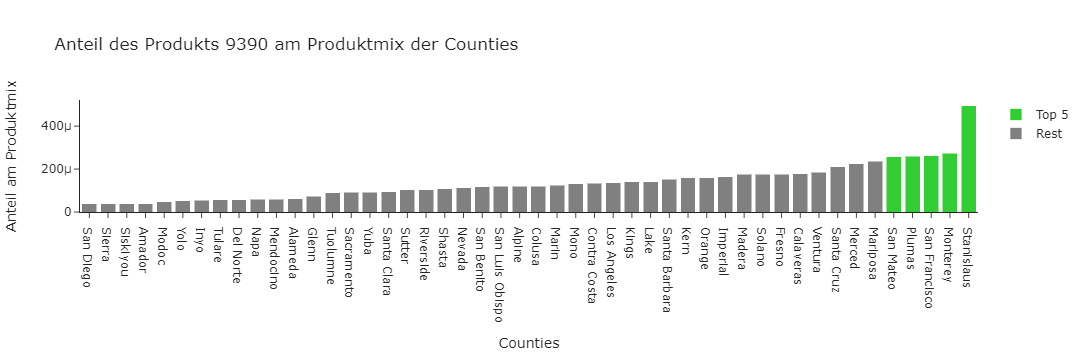

In [42]:
# Second analysis: Order counties by highest product share in given county
df_q2 = df_q2.sort_values(by='Anteil Bestellungen in County', ascending = False)
bins = [0,0.00024,1] # define 2 bins for Top 5 yes/no
labels = ['Rest', 'Top 5']
colors = {'Rest':'gray','Top 5':'limegreen'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels) # generate label for Top 5 yes/no
df_q2=df_q2[df_q2["Anzahl Bestellungen"]>0.007535] # for better visibility in plot: remove all counties with small product share
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county, # for each county
                       y=label_df['Anteil Bestellungen in County'], # append count orders
                       name=label, # name it Top 5 / Rest
                       marker={'color':colors[label]})) # set color of Bar
my_layout = ({"title": "Anteil des Produkts 9390 am Produktmix der Counties",
                       "yaxis": {"title":"Anteil am Produktmix"},
                       "xaxis": {"title":"Counties"},
                       "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'}, template='simple_white')
fig.show()

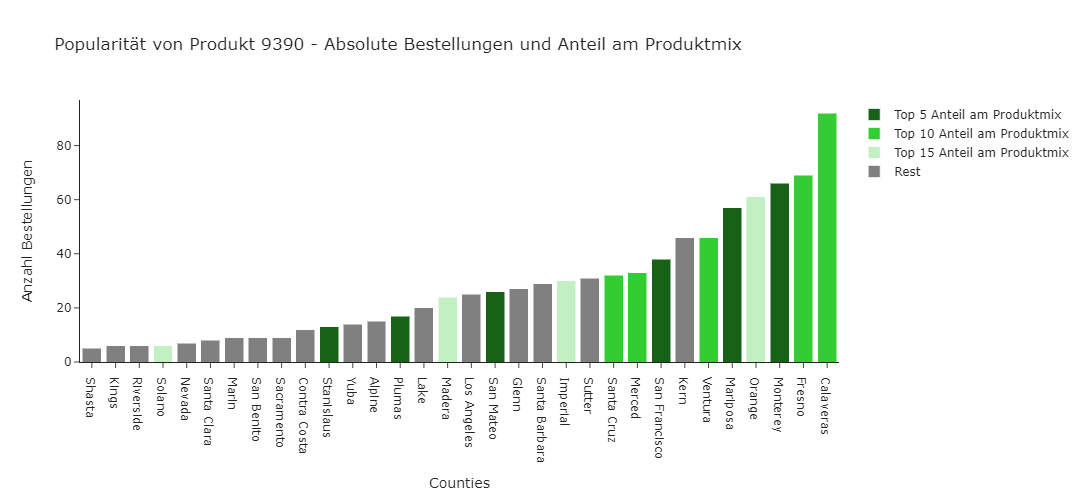

In [43]:
# compare relative to absolute
bins = [0,0.00016,0.0001761,0.000234,1] # in order to achive combination: Bins represent 20 Counties with largest product share
labels = ['Rest', 'Top 15 Anteil am Produktmix','Top 10 Anteil am Produktmix','Top 5 Anteil am Produktmix']
colors = {'Rest':'gray','Top 15 Anteil am Produktmix':'#C2F0C2','Top 10 Anteil am Produktmix':'#32CD32','Top 5 Anteil am Produktmix':'#186218'}
df_q2['label'] = pd.cut(df_q2['Anteil Bestellungen in County'], bins=bins, labels=labels) # generate label for Top 20 yes/no
df_q2=df_q2[df_q2["Anzahl Bestellungen"]>=5] # for better visibility in plot: remove all counties with less than 5 purchases
bars = []
for label, label_df in df_q2.groupby('label'):
    bars.append(go.Bar(x=label_df.county, # for each county
                       y=label_df['Anzahl Bestellungen'], # append count orders
                       name=label, # name it Top 5 / Rest
                       marker={'color':colors[label]})) # set color of Bar
my_layout = ({"title": "Popularität von Produkt 9390 - Absolute Bestellungen und Anteil am Produktmix",
              "yaxis": {"title":"Anzahl Bestellungen"},
              "xaxis": {"title":"Counties"},
              "showlegend": True})
fig = go.FigureWidget(data=bars, layout = my_layout)
fig.update_layout(height=500, width=1100,barmode='stack', xaxis={'categoryorder':'total ascending'},template='simple_white')
fig.show()

#### 4.2.2 Sind die Produkte 9390, 2713, 21883 und 16753 in den gleichen Regionen populär und unpopulär, oder unterscheiden sich die Muster?

In [44]:
# filter to 9390, 2713, 21883 & 16753, group by county and product id and count orders
# rename column
df_q3 = raw[raw.product_id.isin([9390, 2713, 21883, 16753])].groupby(["county","product_id"]).agg({"order_id": "count"})\
        .rename(columns={"order_id": "Anzahl Bestellungen"})
# join sales per product
df_q3 = df_q3.merge(prod_count.rename("Bestellungen pro Produkt"), left_index=True, right_index=True)
# compute fraction/relative measure
df_q3["Anteil Bestellungen"] = df_q3["Anzahl Bestellungen"] / df_q3["Bestellungen pro Produkt"]
df_q3 = df_q3.sort_values(by=["product_id","Anteil Bestellungen"],ascending=False).reset_index()

In [45]:
with urlopen('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson') as response:
    print(response)

In [46]:
# load geodata from california counties
california_geojson = geopandas.GeoDataFrame.from_features(requests.get("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson").json())
all(np.sort(raw.county.unique()) == np.sort(california_geojson.name.unique()))

True

Countybezeichnungen stimmen in Geodaten mit Angaben im Analysedatansatz überein

In [47]:
# load geojson data
geopd = california_geojson[['name','geometry']]
# merge Original Data with geojson data
df_q3g = pd.merge(geopd,df_q3,how='outer',left_on='name',right_on='county').drop('county',axis=1).rename(columns={'geometry':'Koordinaten', 'name':'county'})
# Transform generic DataFrame to GeoDataFrame
df_q3g = geopandas.GeoDataFrame(df_q3g,geometry='Koordinaten')

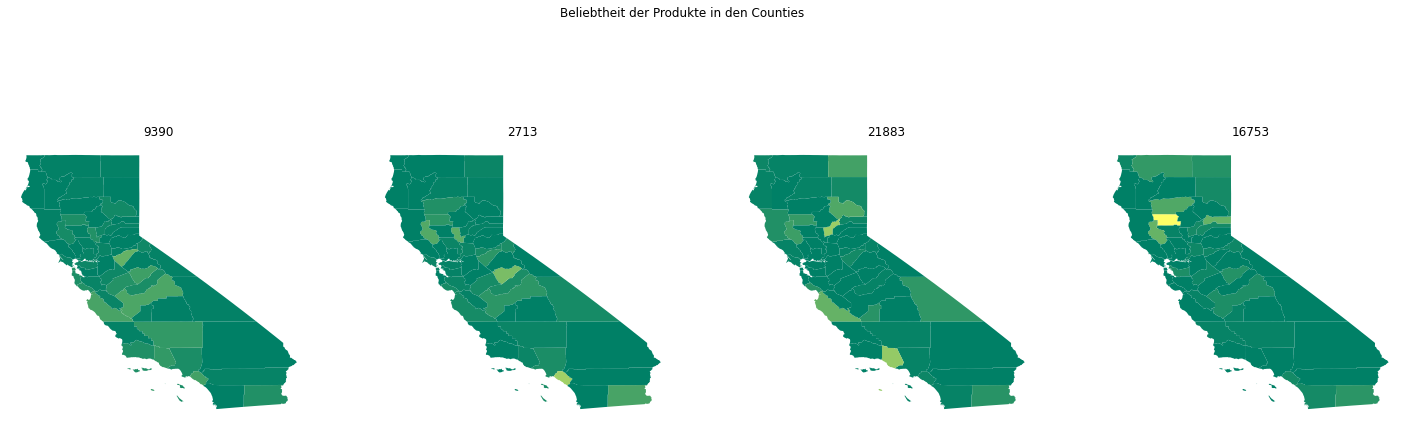

In [48]:
# generate geoplot for popularity of products in each county
cmap = 'summer'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, sharex=True, sharey=True)
fig.suptitle('Beliebtheit der Produkte in den Counties')
pipe(df_q3g, 9390).plot(ax = ax1,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 2713).plot(ax =ax2,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 21883).plot(ax =ax3,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
pipe(df_q3g, 16753).plot(ax =ax4,column='Anteil Bestellungen',cmap=cmap,vmin=0,vmax=0.25)
ax1.set_title('9390')
ax1.axis('off')
ax2.set_title('2713')
ax2.axis('off')
ax3.set_title('21883')
ax3.axis('off')
ax4.set_title('16753')
ax4.axis('off')
fig.set_size_inches(25, 8)
plt.rcParams.update({'font.size': 24})

Effizienter als Erzeugen über Plotly: Legende aus unterern tabelle croppen und Einfügen

In [49]:
# generate DataFrames for visualization of Top5 Counties per Product
df_9390=pipe(df_q3g, 9390)
df_2713=pipe(df_q3g, 2713)
df_21883=pipe(df_q3g, 21883)
df_16753=pipe(df_q3g, 16753)
df_9390_t5 = df_9390.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_2713_t5= df_2713.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_21883_t5 = df_21883.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)
df_16753_t5 = df_16753.sort_values('Anteil Bestellungen',ascending=False)[['county','Anzahl Bestellungen','Anteil Bestellungen']].head(5)

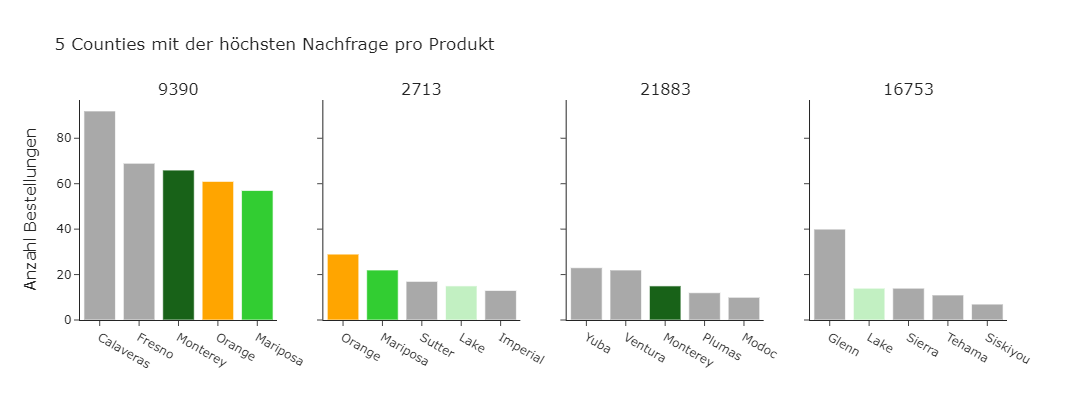

In [50]:
# Generate 4 Barcharts for Top 5 Counties per Product
# Colors represent cooccurence of counties
col = 'darkgray'
colors1=[col]*5
colors2=[col]*5
colors3=[col]*5
colors4=[col]*5
colors1[2]='#186218'
colors1[3]='orange'
colors1[4]='limegreen'
colors2[0]='orange'
colors2[1]='limegreen'
colors2[3]='#C2F0C2'
colors3[2]='#186218'
colors4[1]='#C2F0C2'
fig = make_subplots(rows=1,
                    cols=4,
                    shared_yaxes='all',
                    y_title = 'Anzahl Bestellungen',
                    subplot_titles = ['9390','2713','21883','16753'])

fig.add_trace(
    go.Bar(x=df_9390_t5.county, y=df_9390_t5['Anzahl Bestellungen'], name = '9390',marker_color=colors1),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_2713_t5.county, y=df_2713_t5['Anzahl Bestellungen'], name = '2713',marker_color=colors2),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df_21883_t5.county, y=df_21883_t5['Anzahl Bestellungen'], name = '21883',marker_color=colors3),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df_16753_t5.county, y=df_16753_t5['Anzahl Bestellungen'], name = '16753',marker_color=colors4),
    row=1, col=4
)
fig.update_layout(height=400, width=1200,
                  title_text="5 Counties mit der höchsten Nachfrage pro Produkt",
                  showlegend=False,
                 template = 'simple_white')

fig.show()

In [51]:
# helplist to identify similarities in top 5 counties
simil = df_9390_t5.county.tolist() + df_2713_t5.county.tolist() + df_21883_t5.county.tolist() + df_16753_t5.county.tolist()
print(simil.sort())

None


#### 4.2.3 Welche Counties sind sich ähnlich in Hinblick auf den Produktmix?

In [52]:
# group by county and department and count orders
# pivot to reshape from long to wide
df_q4 = raw.groupby(["county", "department"], as_index=False)[["order_id"]].count()\
        .pivot(index="county", columns="department", values="order_id")
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer, Butte
df_q4.drop(['Trinity','San Bernardino','Placer','Butte'],axis=0,inplace=True)

In [53]:
# Compute Share of Categories in County
df_q4 = df_q4.fillna(0)
df_q4['sum'] = df_q4.sum(axis=1)
for el in df_q4.columns:
    df_q4[f'{el}_r'] = df_q4[el]/df_q4['sum']
df_q4_1 = df_q4.loc[:,'alcohol_r':'snacks_r']

In [54]:
# Generate DataFrame with data to perform Clusteranalysis on
df_cluster = df_q4.loc[:,'alcohol_r':'snacks_r'].fillna(0)
# get different cluster solutions
cluster = [3,4,5,15]
X = df_cluster
for el in cluster:
    # Let algorithm separate cases into cluster
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    # append new Column with Cluster Labeling
    df_cluster[f"{el}-Cluster Lösung"] = kmeans.labels_

In [55]:
# Compare cluster solutions:

# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.20289496215145236
0.19400579379909175
0.1844746668632639
0.2503405860743371


Erkenntnis: Cluster 5 differenziert deutlich stärker zwischen den Daten, 3/4 Cluster kaum Unterschied. Analysen auf 5 Cluster fortführen (15 zu unübersichtlich/aufwändig)

In [56]:
# Calculate cluster deviation for each department
df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)

department
produce_r            0.062313
snacks_r             0.032879
beverages_r          0.023659
household_r          0.011255
frozen_r             0.010528
alcohol_r            0.009881
dairy eggs_r         0.007128
pantry_r             0.006739
canned goods_r       0.006431
bakery_r             0.005285
dry goods pasta_r    0.004275
breakfast_r          0.003909
personal care_r      0.003847
deli_r               0.002954
meat seafood_r       0.002767
babies_r             0.002692
pets_r               0.002190
bulk_r               0.001702
international_r      0.001529
other_r              0.000658
missing_r            0.000276
dtype: float64

Departments mit der größten Standardabweichung sind für die größte Differenzierung zwischen den Clustern zuständig -> diese Departments machen also die größten Unterschiede im Produktmix aus

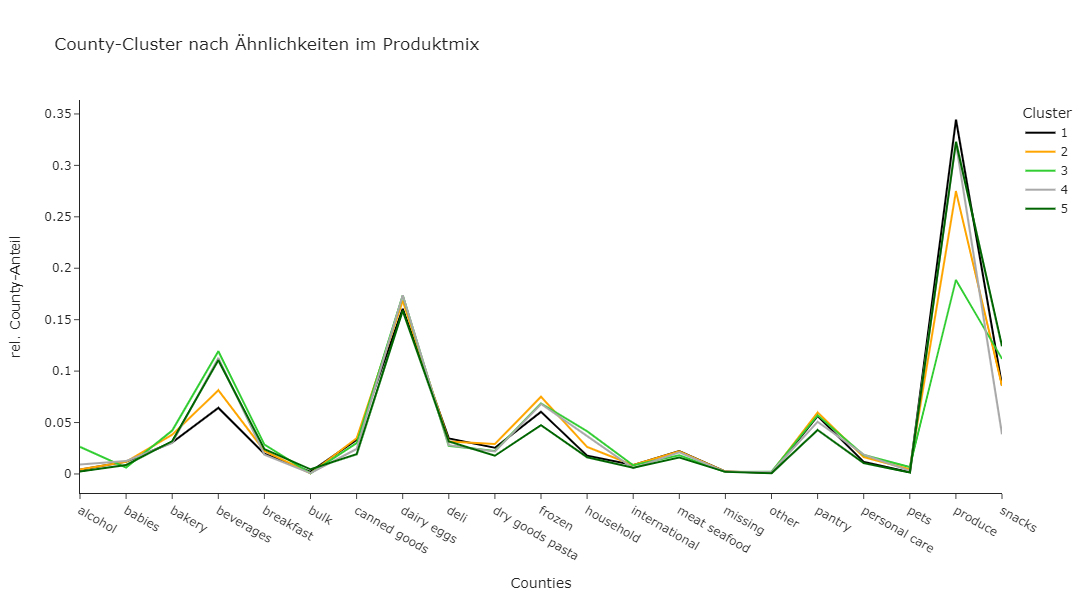

In [57]:
# plot cluster deviation
x = df_cluster.groupby('5-Cluster Lösung').mean().drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x.columns = [el[:-2] for el in x.columns]
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,
              y=y,
              title = 'County-Cluster nach Ähnlichkeiten im Produktmix',
              labels ={'variable':'Cluster',
                       'value':'rel. County-Anteil',
                       'x':'Counties'},
              template = 'simple_white',
             color_discrete_sequence=['black', 'orange','limegreen','darkgray','darkgreen'])
newnames = {'wide_variable_0':'1', 'wide_variable_1':'2','wide_variable_2':'3','wide_variable_3':'4','wide_variable_4':'5'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))               
fig.update_layout(height=600, width=1000)
fig.show()

In [58]:
# deduced from deviation table abvobe as well as visualization: show departments with highest cluster differntiation
x[['produce','beverages','snacks','pantry','alcohol']]

produce  beverages    snacks    pantry   alcohol
5-Cluster Lösung                                                   
0                 0.344454   0.064286  0.086011  0.056412  0.004050
1                 0.275016   0.081416  0.085599  0.059750  0.004302
2                 0.188625   0.119270  0.112045  0.056968  0.026300
3                 0.321323   0.112698  0.038624  0.050792  0.009284
4                 0.322940   0.110625  0.124145  0.042782  0.002301

In [59]:
# Check all counties with high deviation in between clusters for sign.
F_test = df_cluster[['produce_r','beverages_r','snacks_r','pantry_r','alcohol_r','5-Cluster Lösung']]
result = []
for el in range(len(F_test.columns[:-1])): # loop for every county in dataframe
    col = F_test[F_test.columns[[el,5]]] # chose the county and column for Cluster labeling
    result.append(f_oneway(*[col[col["5-Cluster Lösung"]==cluster].iloc[:,0] for cluster in range(0,4)])) # Perform F-Test
result

[F_onewayResult(statistic=109.51595892460938, pvalue=5.83266866924671e-21),
 F_onewayResult(statistic=12.361515512033321, pvalue=4.68194120960895e-06),
 F_onewayResult(statistic=14.69059471243774, pvalue=7.623132059666168e-07),
 F_onewayResult(statistic=0.8197029026089677, pvalue=0.4896775511267919),
 F_onewayResult(statistic=22.910136186330316, pvalue=3.2047521767262014e-09)]

Alle signifikant, außer 4. F-Test = "Pantry"

Schlussfolgerung: Die Cluster differenzieren am besten Anhand von Produce, beverages, snacks und alcohol

In [60]:
print("Counties der Cluster:\n")
for el in range (0,5):
    print('Größe des Clusters: ',len(df_cluster[df_cluster['5-Cluster Lösung']==el].index))
    print(df_cluster[df_cluster['5-Cluster Lösung']==el].index,"\n")

Counties der Cluster:

Größe des Clusters:  12
Index(['Amador', 'Colusa', 'Fresno', 'Plumas', 'Sacramento', 'San Francisco',
       'San Mateo', 'Santa Barbara', 'Santa Cruz', 'Siskiyou', 'Sutter',
       'Yolo'],
      dtype='object', name='county') 

Größe des Clusters:  26
Index(['Alpine', 'Calaveras', 'Contra Costa', 'Glenn', 'Imperial', 'Kings',
       'Lake', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Merced',
       'Monterey', 'Nevada', 'Orange', 'Riverside', 'San Benito',
       'San Joaquin', 'San Luis Obispo', 'Santa Clara', 'Shasta', 'Solano',
       'Stanislaus', 'Tulare', 'Tuolumne', 'Ventura'],
      dtype='object', name='county') 

Größe des Clusters:  9
Index(['Del Norte', 'Humboldt', 'Lassen', 'Modoc', 'Napa', 'San Diego',
       'Sierra', 'Tehama', 'Yuba'],
      dtype='object', name='county') 

Größe des Clusters:  3
Index(['Inyo', 'Mendocino', 'Sonoma'], dtype='object', name='county') 

Größe des Clusters:  4
Index(['Alameda', 'El Dorado', 'Kern', 'Mono'], dtyp

(-124.9074075, -113.9362605, 32.06052445, 42.48327855)

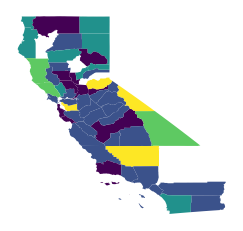

In [61]:
# Visualize Clusters on Califoria map
cluster = df_cluster.reset_index()[['county','5-Cluster Lösung']]
vis_Cluster = pd.merge(cluster,geopd,how='left',left_on='county',right_on='name').drop('county',axis=1).rename(columns={'geometry':'Koordinaten', 'name':'county'})
# Transform generic DataFrame to GeoDataFrame
vis_Cluster = geopandas.GeoDataFrame(vis_Cluster,geometry='Koordinaten')
vis_Cluster.plot('5-Cluster Lösung', legend=False).axis('off')

#### 4.2.4 Welche der TOP 50-Produkte sind sich ähnlich in Hinblick auf die regionale Verteilung?

In [62]:
# compute top 50 products
top50 = prod_count.sort_values().tail(50).index
# filter to top 50 products, group by product and county and count orders
# pivot to reshape from long to wide
df_q5 = raw[raw["product_id"].isin(top50)].groupby(["product_id", "county"], as_index=False)[["order_id"]].count()\
        .pivot(index="product_id", columns="county", values="order_id")
df_q5_1=df_q5.fillna(0)
df_q5_1['sum'] = df_q5_1.sum(axis=1)
# Drop Counties with low product numbers, missing information doesnt allow to deduce product mix
# Drop: Count Products < 1000: Trinity, San Bernardino, Placer, Santa Barbara
df_q5_1.drop(['Trinity','San Bernardino','Placer','Santa Barbara'],axis=1,inplace=True)
# Compute Share of Counties in product
for el in df_q5_1.columns:
    df_q5_1[f'{el}_r'] = df_q5_1[el]/df_q5_1['sum']
df_q5_1 = df_q5_1.loc[:,'Alameda_r':'Yuba_r']

In [63]:
# get different cluster solutions
cluster = [3,4,5,15]
X = df_q5_1
for el in cluster:
    # Let algorithm separate cases into cluster
    kmeans = KMeans(n_clusters=el, random_state=0).fit(X)
    # append new Column with Cluster Labeling
    df_q5_1[f"{el}-Cluster Lösung"] = kmeans.labels_
# get cagetory mean
# remove other cluster solutions
# get variance to evaluate cluster-relevance of each category
# sort cluster_relevance
# Calculate sum to compare Models
df_cluster = df_q5_1
print(df_cluster.groupby('5-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)\
                                      .sum())
print(df_cluster.groupby('4-Cluster Lösung').mean().drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())
print(df_cluster.groupby('15-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','3-Cluster Lösung'],axis=1).std(axis=0).sort_values(ascending=False).sum())

0.16564693864253854
0.16802544451690735
0.1708239530451069
0.22581578517398085


Selbe Argumentation 4 und 5 Clusterlösungen leisten keinen Mehrwert über 3 Clusterlösung, deshalb wird hierfür 3 Clusterlösung gewählt

In [64]:
df_cluster.groupby('4-Cluster Lösung').mean()\
                                      .drop(['3-Cluster Lösung','5-Cluster Lösung','15-Cluster Lösung'],axis=1)\
                                      .std(axis=0)\
                                      .sort_values(ascending=False)


county
Fresno_r             0.015211
Kern_r               0.015143
San Francisco_r      0.013812
Yuba_r               0.009351
Madera_r             0.005911
Lake_r               0.005894
Sacramento_r         0.005763
Sutter_r             0.005568
Los Angeles_r        0.005554
San Mateo_r          0.005312
Ventura_r            0.004366
Nevada_r             0.003980
Mariposa_r           0.003975
Orange_r             0.003821
Mendocino_r          0.003733
Merced_r             0.003437
Modoc_r              0.003375
Monterey_r           0.003299
Alpine_r             0.003145
Stanislaus_r         0.003135
Amador_r             0.003094
Santa Clara_r        0.002850
Glenn_r              0.002434
Santa Cruz_r         0.002338
Marin_r              0.002245
Calaveras_r          0.002120
San Benito_r         0.002006
Lassen_r             0.001918
Imperial_r           0.001788
Plumas_r             0.001638
Napa_r               0.001536
Mono_r               0.001477
Humboldt_r           0.001425
Sol

Couties mit der größten Standardabweichung sind für die größte Differenzierung zwischen den Clustern zuständig -> diese Counties machen also die größten Unterschiede in der Ähnlichkeitsstruktur der Produkte aus

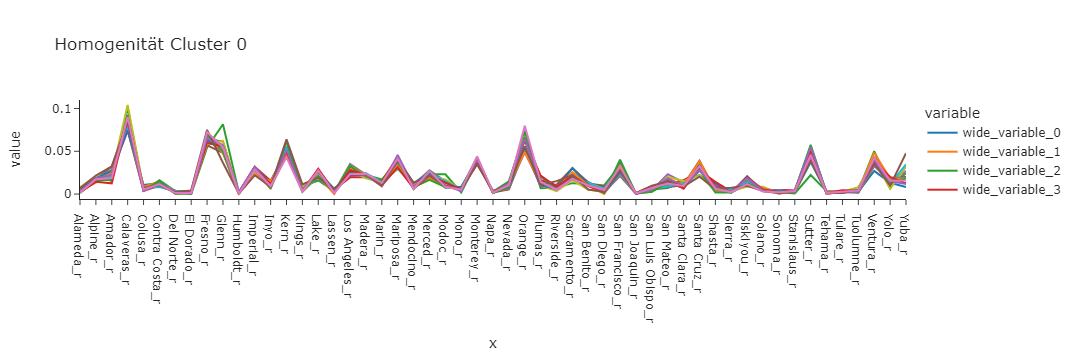

In [65]:
x = df_cluster[df_cluster['3-Cluster Lösung']==0].loc[:,:'Yuba_r']
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,y=y,
             title = 'Homogenität Cluster 0',template='simple_white')
fig.show()

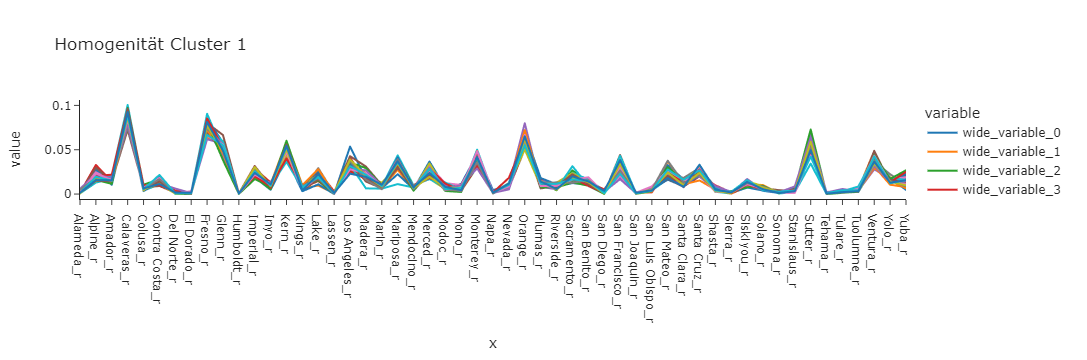

In [66]:
x = df_cluster[df_cluster['3-Cluster Lösung']==1].loc[:,:'Yuba_r']
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,y=y,
             title = 'Homogenität Cluster 1',template='simple_white')
fig.show()

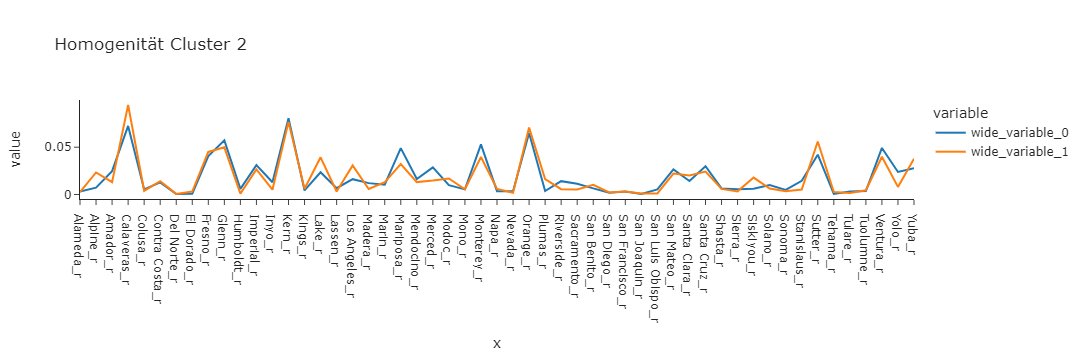

In [67]:
x = df_cluster[df_cluster['3-Cluster Lösung']==2].loc[:,:'Yuba_r']
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,y=y,
             title = 'Homogenität Cluster 2',template='simple_white')
fig.show()

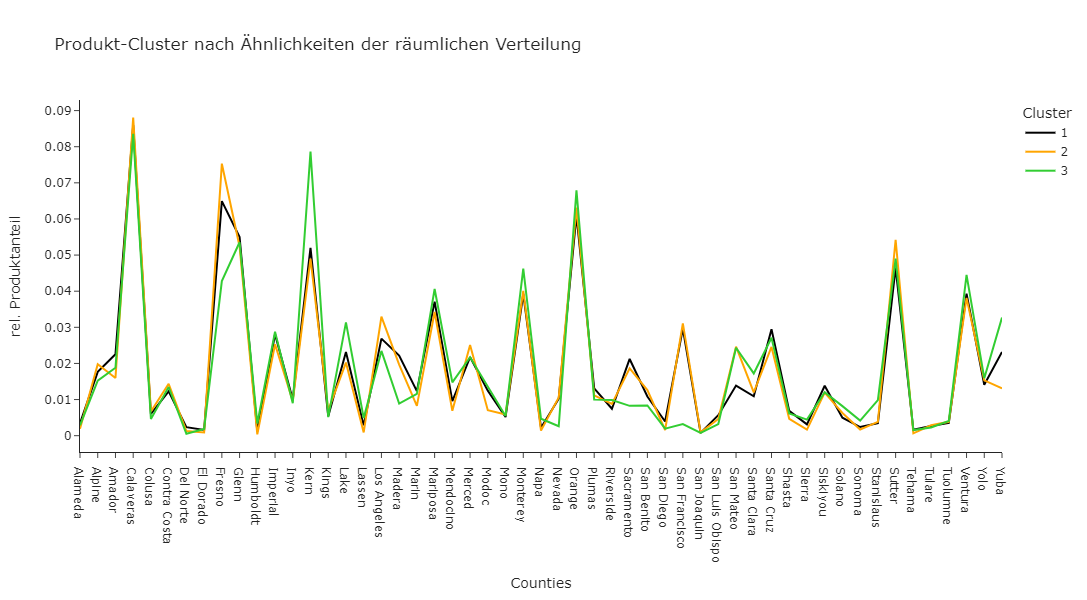

In [68]:
# plot cluster deviation for 3 Clusters
x = df_cluster.groupby('3-Cluster Lösung').mean().drop(['5-Cluster Lösung','4-Cluster Lösung','15-Cluster Lösung'],axis=1)
x.columns = [el[:-2] for el in x.columns]
y = [x.iloc[row] for row in range(len(x))]
fig = px.line(x=x.columns,
              y=y, 
              title = 'Produkt-Cluster nach Ähnlichkeiten der räumlichen Verteilung',
              labels ={'variable':'Cluster',
                       'value':'rel. Produktanteil',
                       'x':'Counties'},
              template = 'simple_white',
             color_discrete_sequence=['black', 'orange','limegreen'])
newnames = {'wide_variable_0':'1', 'wide_variable_1':'2','wide_variable_2':'3'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))               
fig.update_layout(height=600, width=1200)
fig.show()

F- Test performen!

In [69]:
# Alle Counties, die Auffalligkeiten im Plot erkennen lassen, werden auf Signifikanz geprüft
F_test = df_cluster[['Fresno_r','Kern_r','San Francisco_r','Yuba_r','Orange_r','San Mateo_r','Sacramento_r','Madera_r','Sutter_r','Lake_r','3-Cluster Lösung']]
result = []
for el in range(len(F_test.columns[:-1])): # Performe F-Tests für alle auffälligen Counties
    col = F_test[F_test.columns[[el,10]]] # Wähle nur jeweiliges County und Column der Clusterzuordnung
    result.append(f_oneway(*[col[col["3-Cluster Lösung"]==cluster].iloc[:,0] for cluster in range(0,3)])) # Performe F-Test
result

[F_onewayResult(statistic=33.373966800572695, pvalue=9.541728173851237e-10),
 F_onewayResult(statistic=23.528011206616007, pvalue=8.312168864839463e-08),
 F_onewayResult(statistic=22.245101009205175, pvalue=1.5921972790915766e-07),
 F_onewayResult(statistic=15.499340608151238, pvalue=6.7647080190176015e-06),
 F_onewayResult(statistic=0.9200700576076448, pvalue=0.4055482047538943),
 F_onewayResult(statistic=26.84363946183043, pvalue=1.6764726119963986e-08),
 F_onewayResult(statistic=8.42229717574854, pvalue=0.0007479672126777778),
 F_onewayResult(statistic=11.59167972711357, pvalue=8.087179332897481e-05),
 F_onewayResult(statistic=4.695936481592567, pvalue=0.013826474601335282),
 F_onewayResult(statistic=6.841211941072581, pvalue=0.0024678629965250833)]

Nicht Signifikante Unterschiede: F-Test Nummer 5 := Orange

In [70]:
# Signifikante Differenzierung der Cluster erfolgt anhand folgender Counties
F_test.drop(columns=['Orange_r']).columns

Index(['Fresno_r', 'Kern_r', 'San Francisco_r', 'Yuba_r', 'San Mateo_r',
       'Sacramento_r', 'Madera_r', 'Sutter_r', 'Lake_r', '3-Cluster Lösung'],
      dtype='object', name='county')

In [71]:
print("Produkte der Cluster:\n")
for el in range (0,3):
    print('Größe des Clusters: ',len(df_cluster[df_cluster['3-Cluster Lösung']==el].index))
    print(df_cluster[df_cluster['3-Cluster Lösung']==el].index,"\n")

Produkte der Cluster:

Größe des Clusters:  17
Int64Index([ 4605,  4920,  5077,  9076, 13176, 16797, 24852, 26604, 27086,
            28204, 39275, 42265, 45066, 46979, 47626, 49235, 49683],
           dtype='int64', name='product_id') 

Größe des Clusters:  31
Int64Index([ 5876,  8277,  8518, 10749, 17794, 19057, 21137, 21616, 21903,
            21938, 22035, 22935, 24964, 26209, 27104, 27845, 27966, 28985,
            30391, 30489, 31717, 34126, 35951, 37646, 39877, 40706, 41950,
            44359, 45007, 47209, 47766],
           dtype='int64', name='product_id') 

Größe des Clusters:  2
Int64Index([19660, 44632], dtype='int64', name='product_id') 



In [72]:
# Products in Cluster 0
raw[raw["product_id"].isin(df_cluster[df_cluster['3-Cluster Lösung']==0].index)].groupby('product_id').max()[['product_name','department']]

product_name  department
product_id                                    
4605                 Yellow Onions     produce
4920           Seedless Red Grapes     produce
5077        100% Whole Wheat Bread      bakery
9076                   Blueberries      frozen
13176       Bag of Organic Bananas     produce
16797                 Strawberries     produce
24852                       Banana     produce
26604         Organic Blackberries     produce
27086                  Half & Half  dairy eggs
28204           Organic Fuji Apple     produce
39275          Organic Blueberries     produce
42265         Organic Baby Carrots     produce
45066             Honeycrisp Apple     produce
46979                    Asparagus     produce
47626                  Large Lemon     produce
49235          Organic Half & Half  dairy eggs
49683               Cucumber Kirby     produce

In [73]:
# Products in Cluster 1
raw[raw["product_id"].isin(df_cluster[df_cluster['3-Cluster Lösung']==1].index)].groupby('product_id').max()[['product_name','department']]

product_name  department
product_id                                                  
5876                               Organic Lemon     produce
8277                    Apple Honeycrisp Organic     produce
8518                           Organic Red Onion     produce
10749                    Organic Red Bell Pepper     produce
17794                                    Carrots     produce
19057       Organic Large Extra Fancy Fuji Apple     produce
21137                       Organic Strawberries     produce
21616                       Organic Baby Arugula     produce
21903                       Organic Baby Spinach     produce
21938                          Green Bell Pepper     produce
22035                Organic Whole String Cheese  dairy eggs
22935                       Organic Yellow Onion     produce
24964                             Organic Garlic     produce
26209                                      Limes     produce
27104                          Fresh Cauliflower     produce
27845                         Organic Whole Milk  dairy eggs
27966                        Organic Raspberries     produce
28985                      Michigan Organic Kale     produce
30391                           Organic Cucumber     produce
30489                            Original Hummus        deli
31717                           Organic Cilantro     produce
34126              Organic Italian Parsley Bunch     produce
35951            Organic Unsweetened Almond Milk  dairy eggs
37646                        Organic Gala Apples     produce
39877                 Organic Granny Smith Apple     produce
40706                     Organic Grape Tomatoes     produce
41950                     Organic Tomato Cluster     produce
44359                 Organic Small Bunch Celery     produce
45007                           Organic Zucchini     produce
47209                       Organic Hass Avocado     produce
47766                            Organic Avocado     produce

In [74]:
# Products in Cluster 2
raw[raw["product_id"].isin(df_cluster[df_cluster['3-Cluster Lösung']==2].index)].groupby('product_id').max()[['product_name','department']]

product_name department
product_id                                       
19660                     Spring Water  beverages
44632       Sparkling Water Grapefruit  beverages

Cluster 0/1 hauptsächlich produce, Cluster 2 findet die einzigen Beverages